In [2]:
!pip install pytesseract opencv-python

import cv2
import pytesseract
import numpy as np
from sklearn.cluster import DBSCAN
import math


[notice] A new release of pip is available: 23.3.2 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import cv2
import pytesseract
import numpy as np
from sklearn.cluster import DBSCAN
import math

# Function to perform OCR and get bounding boxes
def ocr_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} could not be loaded.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    d = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)

    predictions = []
    for i in range(len(d['text'])):
        if int(d['conf'][i]) > 0:  # Consider only confident predictions
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            predictions.append((d['text'][i], ((x, y), (x + w, y + h))))
    return predictions

def get_distance(predictions):
    """
    Function returns dictionary with (key,value):
        * text : detected text in image
        * center_x : center of bounding box (x)
        * center_y : center of bounding box (y)
        * distance_from_origin : hypotenuse
        * distance_y : distance between y and origin (0,0)
    """
    # Point of origin
    x0, y0 = 0, 0

    # Generate dictionary
    detections = []
    for group in predictions:
        # Get center point of bounding box
        top_left_x, top_left_y = group[1][0]
        bottom_right_x, bottom_right_y = group[1][1]
        center_x, center_y = (top_left_x + bottom_right_x)/2, (top_left_y + bottom_right_y)/2

        # Use the Pythagorean Theorem to solve for distance from origin
        distance_from_origin = math.dist([x0,y0], [center_x, center_y])

        # Calculate difference between y and origin to get unique rows
        distance_y = center_y - y0

        # Append all results
        detections.append({
                            'text': group[0],
                            'center_x': center_x,
                            'center_y': center_y,
                            'distance_from_origin': distance_from_origin,
                            'distance_y': distance_y
                        })

    return detections

def calculate_average_distances(detections):
    """
    Calculate average vertical and horizontal distances between bounding boxes.
    """
    vertical_distances = []
    horizontal_distances = []

    for i in range(len(detections) - 1):
        for j in range(i + 1, len(detections)):
            vertical_distances.append(abs(detections[i]['center_y'] - detections[j]['center_y']))
            horizontal_distances.append(abs(detections[i]['center_x'] - detections[j]['center_x']))

    avg_vertical_distance = np.mean(vertical_distances)
    avg_horizontal_distance = np.mean(horizontal_distances)

    return avg_vertical_distance, avg_horizontal_distance

def cluster_predictions(detections, avg_vertical_distance, avg_horizontal_distance):
    """
    Clusters detections using DBSCAN clustering algorithm with dynamic eps.
    """
    coords = np.array([[det['center_x'], det['center_y']] for det in detections])
    eps = (avg_vertical_distance + avg_horizontal_distance) / 2
    clustering = DBSCAN(eps=eps, min_samples=1).fit(coords)
    clusters = []
    for label in set(clustering.labels_):
        cluster = [detections[i] for i in range(len(detections)) if clustering.labels_[i] == label]
        clusters.append(cluster)
    return clusters

def order_clusters(clusters):
    """
    Orders clusters from top to bottom, and within each cluster, from left to right.
    """
    ordered_clusters = sorted(clusters, key=lambda cluster: cluster[0]['center_y'])
    for cluster in ordered_clusters:
        cluster.sort(key=lambda x: x['center_x'])
    return ordered_clusters

def extract_text_from_clusters(clusters):
    """
    Extracts and concatenates text from ordered clusters.
    """
    ordered_text = []
    for cluster in clusters:
        line_text = ' '.join([det['text'] for det in cluster])
        ordered_text.append(line_text)
    return ' '.join(ordered_text)

# Example usage with your predictions
image_path = 'Nitrofurantoin1.jpg' # Replace with your image path
try:
    predictions = ocr_image(image_path)
    detections = get_distance(predictions)
    avg_vertical_distance, avg_horizontal_distance = calculate_average_distances(detections)
    clusters = cluster_predictions(detections, avg_vertical_distance, avg_horizontal_distance)
    ordered_clusters = order_clusters(clusters)
    extracted_text = extract_text_from_clusters(ordered_clusters)

    print(f'Extracted Text: {extracted_text}')
except FileNotFoundError as e:
    print(e)


Extracted Text:      4 8     m.Each Mfg. "ach bie <i Store LG Colour capsule UTITROY ae      equivalent Sue: Nitrofurantoin Lic. Nitrofurantoin : * tard hard below shell. No. to to Approved sage : gelatin gelatin IP 30°C, IP i UTITROY Nitrofurante Nitrofurantoin 37/UA/2006 capsu 4 colour protect ay) le Nitrofurantoin St, (Hydrous/Anhydrous) Behe USEC used from 100 ee | contains if in      mg. light. ei. UTITROY.-UTITROY : #4) J ite   Ppp   ee ~   Sara Trolkaa ee GiOMila Leen Dehradun-248197, P   Industrial      UTITROY   Capsules fa Estate, Ls Se   ey UTITROY Uttarakhand, ere USP Ltd. India  UTITROY 3 5 © 7s ee) =< w wm wo — = © 2) DATE-DEC-23 MFG. DATE-JAN-22 EXP, CAP. 0 M,R.P,RS,88,16 INCL, TAXES/1 ALL   


In [4]:
import cv2
import pytesseract
import numpy as np
from sklearn.cluster import DBSCAN
import math
import matplotlib.pyplot as plt

# Function to perform OCR and get bounding boxes
def ocr_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} could not be loaded.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    d = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)

    predictions = []
    for i in range(len(d['text'])):
        if int(d['conf'][i]) > 0:  # Consider only confident predictions
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            predictions.append((d['text'][i], ((x, y), (x + w, y + h))))
    return predictions

image_path = 'Nitrofurantoin1.jpg'  # Replace with your image path
try:
    predictions = ocr_image(image_path)
    print("OCR Predictions:")
    for pred in predictions:
        print(pred)
except FileNotFoundError as e:
    print(e)


OCR Predictions:
('    ', ((0, 0), (499, 532)))
(' ', ((1002, 0), (1914, 218)))
('bie', ((121, 221), (230, 254)))
('i', ((595, 241), (600, 249)))
('le', ((879, 234), (936, 299)))
('contains', ((966, 247), (1259, 309)))
(':', ((1291, 267), (1301, 312)))
('"ach', ((94, 261), (255, 338)))
('hard', ((282, 254), (410, 319)))
('gelatin', ((435, 245), (643, 324)))
('capsu', ((673, 248), (870, 310)))
('4', ((60, 319), (86, 379)))
('Nitrofurantoin', ((107, 348), (510, 430)))
('IP', ((543, 342), (603, 402)))
('(Hydrous/Anhydrous)', ((632, 337), (1375, 435)))
('equivalent', ((104, 455), (408, 537)))
('to', ((432, 454), (487, 508)))
('Nitrofurantoin', ((517, 441), (973, 505)))
('100', ((1009, 447), (1134, 560)))
('mg.', ((1162, 466), (1285, 530)))
('Colour', ((106, 561), (297, 625)))
(':', ((326, 571), (329, 611)))
('Approved', ((352, 544), (660, 623)))
('colour', ((691, 540), (902, 603)))
('used', ((929, 550), (1094, 609)))
('in', ((1127, 567), (1179, 612)))
(' ', ((1554, 256), (2874, 554)))
('Le

In [5]:
def get_distance(predictions):
    """
    Function returns dictionary with (key,value):
        * text : detected text in image
        * center_x : center of bounding box (x)
        * center_y : center of bounding box (y)
        * distance_from_origin : hypotenuse
        * distance_y : distance between y and origin (0,0)
    """
    # Point of origin
    x0, y0 = 0, 0

    # Generate dictionary
    detections = []
    for group in predictions:
        # Get center point of bounding box
        top_left_x, top_left_y = group[1][0]
        bottom_right_x, bottom_right_y = group[1][1]
        center_x, center_y = (top_left_x + bottom_right_x)/2, (top_left_y + bottom_right_y)/2

        # Use the Pythagorean Theorem to solve for distance from origin
        distance_from_origin = math.dist([x0,y0], [center_x, center_y])

        # Calculate difference between y and origin to get unique rows
        distance_y = center_y - y0

        # Append all results
        detections.append({
                            'text': group[0],
                            'center_x': center_x,
                            'center_y': center_y,
                            'distance_from_origin': distance_from_origin,
                            'distance_y': distance_y
                        })

    return detections

detections = get_distance(predictions)
print("Detections with distances:")
for det in detections:
    print(det)


Detections with distances:
{'text': '    ', 'center_x': 249.5, 'center_y': 266.0, 'distance_from_origin': 364.7002193583108, 'distance_y': 266.0}
{'text': ' ', 'center_x': 1458.0, 'center_y': 109.0, 'distance_from_origin': 1462.068739834075, 'distance_y': 109.0}
{'text': 'bie', 'center_x': 175.5, 'center_y': 237.5, 'distance_from_origin': 295.3074668883264, 'distance_y': 237.5}
{'text': 'i', 'center_x': 597.5, 'center_y': 245.0, 'distance_from_origin': 645.7795676544745, 'distance_y': 245.0}
{'text': 'le', 'center_x': 907.5, 'center_y': 266.5, 'distance_from_origin': 945.8216005146002, 'distance_y': 266.5}
{'text': 'contains', 'center_x': 1112.5, 'center_y': 278.0, 'distance_from_origin': 1146.7084415839975, 'distance_y': 278.0}
{'text': ':', 'center_x': 1296.0, 'center_y': 289.5, 'distance_from_origin': 1327.9406048464668, 'distance_y': 289.5}
{'text': '"ach', 'center_x': 174.5, 'center_y': 299.5, 'distance_from_origin': 346.62732148519393, 'distance_y': 299.5}
{'text': 'hard', 'cente

In [6]:
def calculate_average_distances(detections):
    """
    Calculate average vertical and horizontal distances between bounding boxes.
    """
    vertical_distances = []
    horizontal_distances = []

    for i in range(len(detections) - 1):
        for j in range(i + 1, len(detections)):
            vertical_distances.append(abs(detections[i]['center_y'] - detections[j]['center_y']))
            horizontal_distances.append(abs(detections[i]['center_x'] - detections[j]['center_x']))

    avg_vertical_distance = np.mean(vertical_distances)
    avg_horizontal_distance = np.mean(horizontal_distances)

    return avg_vertical_distance, avg_horizontal_distance

avg_vertical_distance, avg_horizontal_distance = calculate_average_distances(detections)
print(f"Average Vertical Distance: {avg_vertical_distance}")
print(f"Average Horizontal Distance: {avg_horizontal_distance}")


Average Vertical Distance: 769.2113614341085
Average Horizontal Distance: 1207.281734496124


In [7]:
def cluster_predictions(detections, avg_vertical_distance, avg_horizontal_distance):
    """
    Clusters detections using DBSCAN clustering algorithm with dynamic eps.
    """
    coords = np.array([[det['center_x'], det['center_y']] for det in detections])
    eps = (avg_vertical_distance + avg_horizontal_distance) / 2 * 6  # Adjusting the eps factor for better clustering
    clustering = DBSCAN(eps=eps, min_samples=1).fit(coords)
    clusters = []
    for label in set(clustering.labels_):
        cluster = [detections[i] for i in range(len(detections)) if clustering.labels_[i] == label]
        clusters.append(cluster)
    return clusters

clusters = cluster_predictions(detections, avg_vertical_distance, avg_horizontal_distance)
print("Clusters formed:")
for cluster in clusters:
    print([det['text'] for det in cluster])


Clusters formed:
['    ', ' ', 'bie', 'i', 'le', 'contains', ':', '"ach', 'hard', 'gelatin', 'capsu', '4', 'Nitrofurantoin', 'IP', '(Hydrous/Anhydrous)', 'equivalent', 'to', 'Nitrofurantoin', '100', 'mg.', 'Colour', ':', 'Approved', 'colour', 'used', 'in', ' ', 'Leen', 'capsule', 'shell.', '|', 'GiOMila', '3', '<i', 'Behe', 'ei.', 'Trolkaa', 'ere', 'Ltd.', 'Store', 'below', '30°C,', 'protect', 'from', 'light.', 'Sara', 'Industrial', 'Estate,', '5', 'Mfg.', 'Lic.', 'No.', ':', '37/UA/2006', 'Dehradun-248197,', 'Uttarakhand,', 'India', '©', 'UTITROY', 'UTITROY', 'UTITROY.-UTITROY', 'UTITROY', 'UTITROY', ' UTITROY', '*', 'Nitrofurantoin', 'Capsules', 'USP', ' ', '    ', ' ', ' ', 'm.Each', 'tard', 'gelatin', 'Nitrofurantoin', 'IP', '8', 'ae', 'to', 'Nitrofurante', 'if', 'J', '~', 'P', 'Se', 'ey', 'LG', 'Sue:', 'sage', 'ay)', 'USEC', 'ite', 'Ls', '4', 'St,', 'ee', '#4)', 'Ppp', 'ee', 'ee', 'fa', '  ', ' ', ' ', '    ', '   ', ' ', '0', 'CAP.', 'DATE-DEC-23', 'EXP,', 'M,R.P,RS,88,16', 'INCL

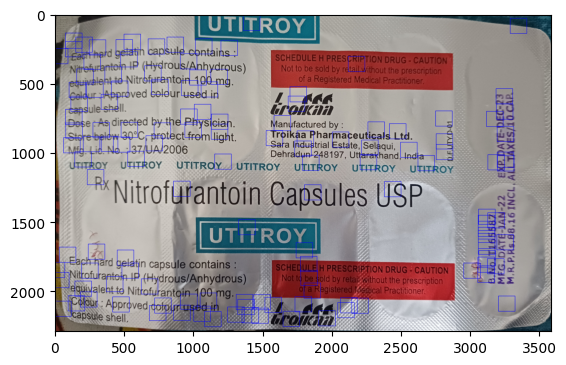

In [8]:
def visualize_clusters(image_path, clusters):
    image = cv2.imread(image_path)
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
    
    for idx, cluster in enumerate(clusters):
        color = colors[idx % len(colors)]
        for det in cluster:
            top_left = (int(det['center_x'] - 100), int(det['center_y'] - 100))  # Adjust as needed
            bottom_right = (int(det['center_x'] + 20), int(det['center_y'] + 10))  # Adjust as needed
            cv2.rectangle(image, top_left, bottom_right, color, 2)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_clusters(image_path, clusters)


In [9]:
def order_clusters(clusters):
    """
    Orders clusters from top to bottom, and within each cluster, from left to right.
    """
    ordered_clusters = sorted(clusters, key=lambda cluster: cluster[0]['center_y'])
    for cluster in ordered_clusters:
        cluster.sort(key=lambda x: x['center_x'])
    return ordered_clusters

def extract_text_from_clusters(clusters):
    """
    Extracts and concatenates text from ordered clusters.
    """
    ordered_text = []
    for cluster in clusters:
        line_text = ' '.join([det['text'] for det in cluster])
        ordered_text.append(line_text)
    return ' '.join(ordered_text)

ordered_clusters = order_clusters(clusters)
extracted_text = extract_text_from_clusters(ordered_clusters)

print(f'Extracted Text: {extracted_text}')


Extracted Text:      4 8     m.Each Mfg. "ach bie <i Store LG Colour capsule UTITROY ae      equivalent Sue: Nitrofurantoin Lic. Nitrofurantoin : * tard hard below shell. No. to to Approved sage : gelatin gelatin IP 30°C, IP i UTITROY Nitrofurante Nitrofurantoin 37/UA/2006 capsu 4 colour protect ay) le Nitrofurantoin St, (Hydrous/Anhydrous) Behe USEC used from 100 ee | contains if in      mg. light. ei. UTITROY.-UTITROY : #4) J ite   Ppp   ee ~   Sara Trolkaa ee GiOMila Leen Dehradun-248197, P   Industrial      UTITROY   Capsules fa Estate, Ls Se   ey UTITROY Uttarakhand, ere USP Ltd. India  UTITROY 3 5 © 7s ee) =< w wm wo — = © 2) DATE-DEC-23 MFG. DATE-JAN-22 EXP, CAP. 0 M,R.P,RS,88,16 INCL, TAXES/1 ALL   


In [14]:
import re
import pandas as pd
import qrcode

# Sample extracted text
extracted_text = """
4 8 m.Each Mfg. "ach bie <i Store LG Colour capsule UTITROY ae equivalent Sue: Nitrofurantoin Lic. Nitrofurantoin : * tard hard below shell. No. to to Approved sage : gelatin gelatin IP 30°C, IP i UTITROY Nitrofurante Nitrofurantoin 37/UA/2006 capsu 4 colour protect ay) le Nitrofurantoin St, (Hydrous/Anhydrous) Behe USEC used from 100 ee | contains if in mg. light. ei. UTITROY.-UTITROY : #4) J ite Ppp ee ~ Sara Trolkaa ee GiOMila Leen Dehradun-248197, P Industrial UTITROY Capsules fa Estate, Ls Se ey UTITROY Uttarakhand, ere USP Ltd. India UTITROY 3 5 © 7s ee) =< w wm wo — = © 2) DATE-DEC-23 MFG. DATE-JAN-22 EXP, CAP. 0 M,R.P,RS,88,16 INCL, TAXES/1 ALL
"""

# Extract tablet name
tablet_name_match = re.search(r'\b[A-Z][A-Za-z\s]*\s*Capsules\s*USP\b', extracted_text)
tablet_name = tablet_name_match.group(0) if tablet_name_match else "Not found"

# Extract dosage
dosage_match = re.search(r'\b\d+\s*mg\b', extracted_text)
dosage = dosage_match.group(0) if dosage_match else "As prescribed"

# Extract manufacturing date
mfg_date_match = re.search(r'\bDATE-([A-Za-z]+-\d{2})\s*MFG\.', extracted_text)
mfg_date = mfg_date_match.group(1).strip() if mfg_date_match else "Not found"

# Extract expiry date
expiry_date_match = re.search(r'\bDATE-([A-Za-z]+-\d{2})\s*EXP', extracted_text)
expiry_date = expiry_date_match.group(1).strip() if expiry_date_match else "Not found"

# Extract MRP
mrp_match = re.search(r'\bRS,\s*(\d+[^\d]*\d+)', extracted_text, re.IGNORECASE)
mrp = mrp_match.group(1).replace(",", ".").replace(" ", "").replace("-", "") if mrp_match else "Not found"


print(f"Tablet Name: {tablet_name}")
print(f"Dosage: {dosage}")
print(f"Manufacturing Date: {mfg_date}")
print(f"Expiry Date: {expiry_date}")
print(f"MRP: {mrp}")

# Save the extracted information in an Excel file
data = {
    'Medicine Name': [tablet_name],
    'Dosage': [dosage],
    'Manufacture Date': [mfg_date],
    'Expiry Date': [expiry_date],
    'MRP': [mrp]
}

df = pd.DataFrame(data)
excel_file = 'medicine_info.xlsx'
df.to_excel(excel_file, index=False)
print(f"Extracted information saved to {excel_file}")

# Read the Excel file and generate QR codes
df = pd.read_excel(excel_file)

def generate_qr_code(medicine_name, dosage, manufacture_date, expiry_date, mrp, file_path):
    # Prepare the data to be encoded in the QR code
    data = (f"Medicine Name: {medicine_name}\n"
            f"Dosage: {dosage}\n"
            f"Manufacture Date: {manufacture_date}\n"
            f"Expiry Date: {expiry_date}\n"
            f"MRP: {mrp}")
    


Tablet Name: Not found
Dosage: As prescribed
Manufacturing Date: DEC-23
Expiry Date: JAN-22
MRP: 88.16
Extracted information saved to medicine_info.xlsx


In [ ]:
# Save the extracted information in an Excel file
data = {
    'Medicine Name': [tablet_name],
    'Dosage': [dosage],
    'Manufacture Date': [mfg_date],
    'Expiry Date': [expiry_date],
    'MRP': [mrp]
}

df = pd.DataFrame(data)
excel_file = 'medicine_info.xlsx'
df.to_excel(excel_file, index=False)
print(f"Extracted information saved to {excel_file}")

# Read the Excel file and generate QR codes
df = pd.read_excel(excel_file)

def generate_qr_code(medicine_name, dosage, manufacture_date, expiry_date, mrp, file_path):
    # Prepare the data to be encoded in the QR code
    data = (f"Medicine Name: {medicine_name}\n"
            f"Dosage: {dosage}\n"
            f"Manufacture Date: {manufacture_date}\n"
            f"Expiry Date: {expiry_date}\n"
            f"MRP: {mrp}")
    
    # Generate the QR code
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )
    qr.add_data(data)
    qr.make(fit=True)

    # Create an image from the QR code instance
    img = qr.make_image(fill='black', back_color='white')

    # Save the image to a file
    img.save(file_path)

# Generate QR codes for each row in the DataFrame
for index, row in df.iterrows():
    file_path = f"qr_code_{index+1}.png"
    generate_qr_code(row['Medicine Name'], row['Dosage'], row['Manufacture Date'], row['Expiry Date'], row['MRP'], file_path)
    print(f"QR code generated and saved as {file_path}")

In [27]:
import re
import pandas as pd
import qrcode

# Sample extracted text
extracted_text = """
4 8 m.Each Mfg. "ach bie <i Store LG Colour capsule UTITROY ae equivalent Sue: Nitrofurantoin Lic. Nitrofurantoin : * tard hard below shell. No. to to Approved sage : gelatin gelatin IP 30°C, IP i UTITROY Nitrofurante Nitrofurantoin 37/UA/2006 capsu 4 colour protect ay) le Nitrofurantoin St, (Hydrous/Anhydrous) Behe USEC used from 100 ee | contains if in mg. light. ei. UTITROY.-UTITROY : #4) J ite Ppp ee ~ Sara Trolkaa ee GiOMila Leen Dehradun-248197, P Industrial UTITROY Capsules fa Estate, Ls Se ey UTITROY Uttarakhand, ere USP Ltd. India UTITROY 3 5 © 7s ee) =< w wm wo — = © 2) DATE-DEC-23 MFG. DATE-JAN-22 EXP, CAP. 0 M,R.P,RS,88,16 INCL, TAXES/1 ALL
"""

# Load the medicine database
database_file = 'medName.xlsx'
df_database = pd.read_excel(database_file)

# Normalize the extracted text
normalized_text = extracted_text.lower()

# Normalize the database entries
df_database['normalized_name'] = df_database['Name'].str.lower().str.replace(" ", "")

# Initialize variables for extracted information
tablet_name = "Not found"
composition = "Not found"

# Check for the name of the medicine in the normalized text
for _, row in df_database.iterrows():
    if row['normalized_name'] in normalized_text:
        tablet_name = row['Name']
        composition = row['composition']
        break

# Extract dosage
dosage_match = re.search(r'\b\d+\s*mg\b', extracted_text)
dosage = dosage_match.group(0) if dosage_match else "As prescribed"

# Extract manufacturing date
mfg_date_match = re.search(r'\bDATE-([A-Za-z]+-\d{2})\s*MFG\.', extracted_text)
mfg_date = mfg_date_match.group(1).strip() if mfg_date_match else "Not found"

# Extract expiry date
expiry_date_match = re.search(r'\bDATE-([A-Za-z]+-\d{2})\s*EXP', extracted_text)
expiry_date = expiry_date_match.group(1).strip() if expiry_date_match else "Not found"

# Extract MRP
mrp_match = re.search(r'\bRS,\s*(\d+[^\d]*\d+)', extracted_text, re.IGNORECASE)
mrp = mrp_match.group(1).replace(",", ".").replace(" ", "").replace("-", "") if mrp_match else "Not found"

print(f"Matched Medicine Name: {tablet_name}")
print(f"Composition: {composition}")
print(f"Dosage: {dosage}")
print(f"Manufacturing Date: {mfg_date}")
print(f"Expiry Date: {expiry_date}")
print(f"MRP: {mrp}")

# Generate and save the QR code if a match was found
if tablet_name != "Not found":
    # Prepare the data for the QR code
    data = (f"Medicine Name: {tablet_name}\n"
            f"Composition: {composition}\n"
            f"Dosage: {dosage}\n"
            f"Manufacture Date: {mfg_date}\n"
            f"Expiry Date: {expiry_date}\n"
            f"MRP: {mrp}")

    # Generate the QR code
    qr = qrcode.QRCode(
        version=None,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )
    qr.add_data(data)
    qr.make(fit=True)

    img = qr.make_image(fill='black', back_color='white')
    file_path = f"qr_code_{tablet_name}.png"
    img.save(file_path)

    print(f"QR code generated and saved as {file_path}")
else:
    print("No matching medicine found in the database.")


Matched Medicine Name: Nitrofurantoin
Composition: Nitrofurantoin (typically available in 50 mg and 100 mg doses)
Dosage: As prescribed
Manufacturing Date: DEC-23
Expiry Date: JAN-22
MRP: 88.16
QR code generated and saved as qr_code_Nitrofurantoin.png
